<a href="https://colab.research.google.com/github/dmldatasci/nonprofit-seeding-deep-learning/blob/main/AlphabetSoup_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alphabet Soup Application Classifier

## Data Preprocessing

In [142]:
# load dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf

In [143]:
application_df = pd.read_csv('https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv')
application_df.head(5)

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [144]:
# drop the non-beneficial ID columns, 'EIN' and 'NAME'
application_df = application_df.drop('EIN', axis=1)
application_df.head(5)

,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [145]:
# determine the number of unique values in each column
application_df.nunique()

NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [146]:
# look at NAME value counts for binning
name_counts = application_df['NAME'].value_counts()
name_counts[name_counts > 1]

NAME
PARENT BOOSTER USA INC                                            1260
TOPS CLUB INC                                                      765
UNITED STATES BOWLING CONGRESS INC                                 700
WASHINGTON STATE UNIVERSITY                                        492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC                    408
                                                                  ... 
VETERANS OF FOREIGH WARS OF THE UNITED STATES DEPT OF COLORADO       2
ETA PHI BETA SORORITY INC                                            2
POINT MAN INTERNATIONAL MINISTRIES                                   2
MULTI COMMUNITY DIVERSIFIED SERVICES INC                             2
VETERANS OF FOREIGN WARS AUXILIARY                                   2
Name: count, Length: 792, dtype: int64

In [148]:
# choose a cutoff value and create a list of names to be replaced
names_to_replace = name_counts[name_counts < 10].index

# replace in dataframe
for n in names_to_replace:
    application_df['NAME'] = application_df['NAME'].replace(n,"Other")

# check to make sure binning was successful
application_df['NAME'].value_counts()

NAME
Other                                      21022
PARENT BOOSTER USA INC                      1260
TOPS CLUB INC                                765
UNITED STATES BOWLING CONGRESS INC           700
WASHINGTON STATE UNIVERSITY                  492
                                           ...  
CASCADE 4-H FOUNDATION                        10
FREE & ACCEPTED MASONS OF WASHINGTON          10
NEW MEXICO GARDEN CLUBS INC                   10
NATIONAL ASSOCIATION OF HISPANIC NURSES       10
UNION OF CALIFORNIA STATE WORKERS             10
Name: count, Length: 223, dtype: int64

In [149]:
# look at APPLICATION_TYPE value counts for binning
application_df['APPLICATION_TYPE'].value_counts()

APPLICATION_TYPE
T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: count, dtype: int64

In [150]:
# choose a cutoff value and create a list of application types to be replaced
app_counts = pd.DataFrame({'APPLICATION_TYPE' : application_df['APPLICATION_TYPE'].value_counts().index, 
                           'counts' : application_df['APPLICATION_TYPE'].value_counts().values}).set_index('APPLICATION_TYPE')
application_types_to_replace = app_counts.loc[app_counts['counts'] <= 500].index

# replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# check to make sure binning was successful
application_df['APPLICATION_TYPE'].value_counts()

APPLICATION_TYPE
T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: count, dtype: int64

In [151]:
# look at CLASSIFICATION value counts for binning
application_df['CLASSIFICATION'].value_counts()

CLASSIFICATION
C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: count, Length: 71, dtype: int64

In [152]:
# look at CLASSIFICATION value counts >1
app_counts = application_df['CLASSIFICATION'].value_counts()
app_counts[app_counts > 1]

CLASSIFICATION
C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
C1230       36
C1400       34
C7200       32
C2300       32
C1240       30
C8000       20
C7120       18
C1500       16
C1800       15
C6000       15
C1250       14
C8200       11
C1238       10
C1278       10
C1235        9
C1237        9
C7210        7
C2400        6
C1720        6
C4100        6
C1257        5
C1600        5
C1260        3
C2710        3
C0           3
C3200        2
C1234        2
C1246        2
C1267        2
C1256        2
Name: count, dtype: int64

In [153]:
# choose a cutoff value and create a list of classifications to be replaced
classifications_to_replace = app_counts[app_counts < 100].index

# replace in dataframe
for cls in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")

# check to make sure binning was successful
application_df['CLASSIFICATION'].value_counts()

CLASSIFICATION
C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
Other      669
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
Name: count, dtype: int64

In [154]:
# convert categorical data to numeric with `pd.get_dummies`
cat_var = [col for col in application_df if application_df[col].dtypes=='object']

dummy_df = pd.get_dummies(application_df[cat_var])
dummy_df.head(5)

,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALPHA PHI SIGMA,NAME_ALPHA PHI SIGMA INC,NAME_ALTRUSA INTERNATIONAL FOUNDATION INC,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,NAME_AMERICAN ART THERAPY ASSOCIATION INC,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False


In [155]:
# incorporate dummy variables into the data frame and drop categorical variables
clean_df = pd.concat([application_df, dummy_df], axis=1)
clean_df = clean_df.drop(cat_var, axis=1)
clean_df.head(5)

,STATUS,ASK_AMT,IS_SUCCESSFUL,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALPHA PHI SIGMA,NAME_ALPHA PHI SIGMA INC,NAME_ALTRUSA INTERNATIONAL FOUNDATION INC,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,1,108590,1,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
2,1,5000,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,1,6692,1,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,1,142590,1,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False


In [156]:
# split our preprocessed data into our features and target arrays
X = clean_df.drop('IS_SUCCESSFUL', axis=1)
y = clean_df['IS_SUCCESSFUL']

# split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=80)
print(f"""
The dimensions of X_train are {X_train.shape}.
The dimensions of X_test are {X_test.shape}.
The dimensions of y_train are {y_train.shape}.
The dimensions of y_test are {y_test.shape}.
""")


The dimensions of X_train are (25724, 272).
The dimensions of X_test are (8575, 272).
The dimensions of y_train are (25724,).
The dimensions of y_test are (8575,).



In [157]:
# instantiate a StandardScaler
scaler = StandardScaler()

# fit the StandardScaler
X_scaler = scaler.fit(X_train)

# scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Compile, Train & Evaluate the Model

In [161]:
nn_model = tf.keras.models.Sequential()

# define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn_model.add(tf.keras.layers.Dense(units=15, activation="relu", input_dim=(X_train.shape[1])))

# first hidden layer
nn_model.add(tf.keras.layers.Dense(units=7, activation="tanh"))

# second hidden layer
# nn_model.add(tf.keras.layers.Dense(units=20, activation="relu"))

# output layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 15)                4095      
                                                                 
 dense_24 (Dense)            (None, 7)                 112       
                                                                 
 dense_25 (Dense)            (None, 1)                 8         
                                                                 
Total params: 4215 (16.46 KB)
Trainable params: 4215 (16.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [162]:
# compile the model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [163]:
# train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
804/804 [==============================] - 1s 551us/step - loss: 0.5167 - accuracy: 0.7498
Epoch 2/100
804/804 [==============================] - 0s 470us/step - loss: 0.4559 - accuracy: 0.7817
Epoch 3/100
804/804 [==============================] - 0s 465us/step - loss: 0.4463 - accuracy: 0.7868
Epoch 4/100
804/804 [==============================] - 0s 460us/step - loss: 0.4427 - accuracy: 0.7863
Epoch 5/100
804/804 [==============================] - 0s 470us/step - loss: 0.4398 - accuracy: 0.7894
Epoch 6/100
804/804 [==============================] - 0s 490us/step - loss: 0.4384 - accuracy: 0.7889
Epoch 7/100
804/804 [==============================] - 0s 465us/step - loss: 0.4370 - accuracy: 0.7895
Epoch 8/100
804/804 [==============================] - 0s 466us/step - loss: 0.4367 - accuracy: 0.7897
Epoch 9/100
804/804 [==============================] - 0s 519us/step - loss: 0.4356 - accuracy: 0.7891
Epoch 10/100
804/804 [==============================] - 0s 519us/step - l

In [164]:
# evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=5)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Loss: 0.4503304660320282, Accuracy: 0.7823906540870667


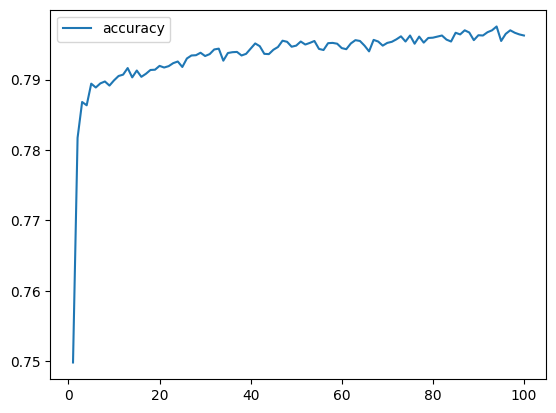

In [165]:
import matplotlib.pyplot as plt

# create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [166]:
# create a method that creates a new sequential model with hyperparameter options
def create_model(hp):
    nn_model_o = tf.keras.models.Sequential()

    # allow `keras-tuner` to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
    # allow keras-tuner to decide number of neurons in first layer
    nn_model_o.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=20,
        step=2), activation=activation, input_dim=49))

    # allow keras-tuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        activation = hp.Choice('activation',['relu','tanh','sigmoid'])
        nn_model_o.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=20,
            step=2),
            activation=activation))
    
    nn_model_o.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # compile the model
    nn_model_o.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model_o

In [167]:
# import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=100,
    hyperband_iterations=2)

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [168]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=100,validation_data=(X_test_scaled,y_test))

INFO:tensorflow:Oracle triggered exit


In [169]:
# export the v1 model to HDF5 file
nn_model.save("output/AlphabetSoupCharity_Optimization.h5")

/Users/davidlevy/Documents/Work/education/berkeley_ds/module_challenges/deep-learning-challenge/.venv/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
